<a href="https://colab.research.google.com/github/soumitrahazra/My_Data_Analysis_Codes/blob/main/Neutral_Line_Parameters_from_Solar_Vector_Magnetogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The neutral line is defined as the boundary between regions where Bz is positive and negative. We detect these lines by finding where the sign of Bz changes (zero-crossings). We can calculate the length of the neutral line by summing up the pixels where the neutral line condition holds.



In [ ]:
!pip install heliopy
!pip install requests

In [ ]:
!pip install sunpy[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.9/961.9 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 M

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage
from sunpy.net import Fido, attrs as a
from astropy import units as u
import sunpy.map
import matplotlib.pyplot as plt

In [16]:
import json, urllib, numpy as np, matplotlib.pylab as plt, math, requests
from astropy.io import fits
import matplotlib.image as mpimg

In [36]:
def get_the_data():
    url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s[7115][2017.09.05_00_TAI]&op=rs_list&key=IMCRVAL1,NOAA_ARS,T_REC&seg=Bp,Br,Bt,magnetogram"
    response = requests.get(url)
    data = response.json()
    print("Approximating",data['segments'][0]['name'],"as Bx.")
    print("Approximating",data['segments'][1]['name'],"as Bz.")
    print("Approximating",data['segments'][2]['name'],"as -By.")
    print("Approximating",data['segments'][3]['name'],"as Blos.")
    bx = fits.open("http://jsoc.stanford.edu"+data['segments'][0]['values'][0])
    bz = fits.open("http://jsoc.stanford.edu"+data['segments'][1]['values'][0])
    by = fits.open("http://jsoc.stanford.edu"+data['segments'][2]['values'][0])
    blos = fits.open("http://jsoc.stanford.edu"+data['segments'][3]['values'][0])
    by[1].data = -1.0*(np.array(by[1].data)) # flip the sign of by
    bx = bx[1].data
    by = by[1].data
    bz = bz[1].data
    blos = blos[1].data
    IMCRVAL1 = float(data['keywords'][0]['values'][0])
    NOAA_ARS = str(data['keywords'][1]['values'][0])
    T_REC = str(data['keywords'][2]['values'][0])
    xsize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[0])
    ysize = float(data['segments'][0]['dims'][0].rsplit('x', 1)[1])
    return bx, by, bz, blos, IMCRVAL1, NOAA_ARS, T_REC, xsize, ysize


In [38]:
bx, by, bz, blos, IMCRVAL1, NOAA_ARS, T_REC, xsize, ysize = get_the_data()

Approximating Bp as Bx.
Approximating Br as Bz.
Approximating Bt as -By.
Approximating magnetogram as Blos.


In [39]:
bz.shape, bx.shape, by.shape, blos.shape

((448, 688), (448, 688), (448, 688), (448, 688))

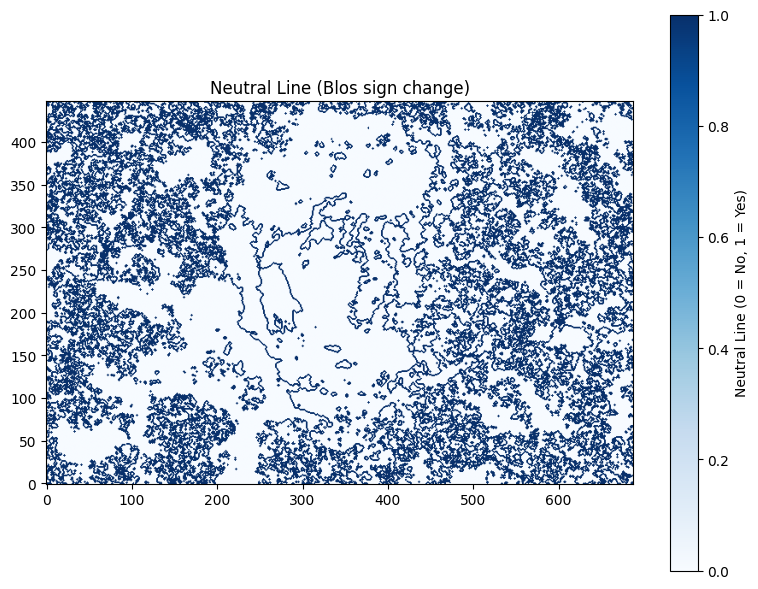

Neutral Line Length (in pixels): 102686
Neutral Line Length (in Mm): 36966.96


In [40]:
#Calculate the neutral line using very simple algorithm
# Step 2: Find the neutral line (where Blos changes sign)
sign_map = np.sign(blos)

# Use binary dilation to detect sign changes between pixels
zero_crossing_mask = (
    (ndimage.binary_dilation(sign_map > 0) & (sign_map < 0)) |
    (ndimage.binary_dilation(sign_map < 0) & (sign_map > 0))
)

# Step 3: Measure the length of the neutral line
# Length of the neutral line in pixels
neutral_line_length_pixels = np.sum(zero_crossing_mask)

# Step 4: Visualize the neutral line
plt.figure(figsize=(8, 6))
plt.imshow(zero_crossing_mask, cmap='Blues', origin='lower')
plt.title('Neutral Line (Blos sign change)')
plt.colorbar(label='Neutral Line (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

# Output the length in pixels
print(f"Neutral Line Length (in pixels): {neutral_line_length_pixels}")

# Convert pixel length to Mm (using the HMI pixel scale)
# HMI Pixel Scale: ~ 0.504 arcseconds per pixel ≈ 0.36 Mm/pixel
pixel_scale_Mm = 0.36  # Mm per pixel
neutral_line_length_Mm = neutral_line_length_pixels * pixel_scale_Mm

print(f"Neutral Line Length (in Mm): {neutral_line_length_Mm}")



You see there is lot of neutral line in the image. All of this neutral line is not responsible for the flare production. So, we will apply a threshold gradient now and will consider only the strong gradient neutral line. We'll focus on neutral lines where the gradient (change in magnetic field) is strong, meaning we're looking for more significant polarity reversals.

In [41]:
blos.shape

(448, 688)

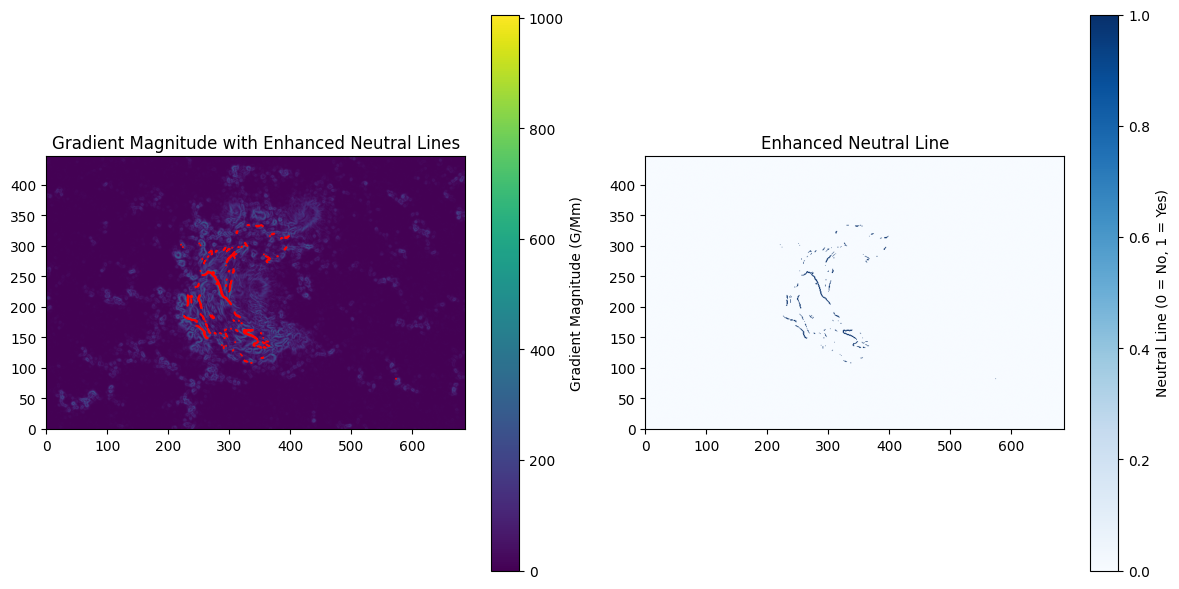

Enhanced Neutral Line Length (in pixels): 780
Enhanced Neutral Line Length (in Mm): 280.8


In [51]:
# Step 2: Compute the gradient of Blos
grad_y, grad_x = np.gradient(blos)
grad_mag = np.hypot(grad_x, grad_y)

# Step 3: Find the neutral line (where Blos changes sign)
sign_map = np.sign(bz)

# Use binary dilation to detect sign changes between pixels
zero_crossing_mask = (
    (ndimage.binary_dilation(sign_map > 0) & (sign_map < 0)) |
    (ndimage.binary_dilation(sign_map < 0) & (sign_map > 0))
)

# Step 4: Apply gradient magnitude threshold
# Let's threshold the gradient magnitude to focus on significant polarity reversals
gradient_threshold = 150  # Customize threshold (G/Mm) based on your data
strong_gradients_mask = grad_mag > gradient_threshold

# Combine zero-crossing mask with gradient threshold mask
enhanced_neutral_line_mask = zero_crossing_mask & strong_gradients_mask

# Step 5: Measure the length of the enhanced neutral line (in pixels)
neutral_line_length_pixels = np.sum(enhanced_neutral_line_mask)

# Step 6: Visualize the neutral line and gradients
plt.figure(figsize=(12, 6))

# Plot the neutral line on top of the gradient magnitude map
plt.subplot(1, 2, 1)
plt.imshow(grad_mag, cmap='viridis', origin='lower')
plt.colorbar(label='Gradient Magnitude (G/Mm)')
plt.contour(enhanced_neutral_line_mask, colors='red', linewidths=1)
plt.title('Gradient Magnitude with Enhanced Neutral Lines')
#plt.colorbar(label='Gradient Magnitude (G/Mm)')

# Plot the neutral line itself
plt.subplot(1, 2, 2)
plt.imshow(enhanced_neutral_line_mask, cmap='Blues', origin='lower')
plt.title('Enhanced Neutral Line')
plt.colorbar(label='Neutral Line (0 = No, 1 = Yes)')

plt.tight_layout()
plt.show()

# Output the length in pixels and in physical units (Mm)
print(f"Enhanced Neutral Line Length (in pixels): {neutral_line_length_pixels}")
pixel_scale_Mm = 0.36  # Mm per pixel (HMI pixel scale)
neutral_line_length_Mm = neutral_line_length_pixels * pixel_scale_Mm
print(f"Enhanced Neutral Line Length (in Mm): {neutral_line_length_Mm}")

A strong field neutral line refers to the line in the solar surface where the magnetic field strength is significant, and the field changes its polarity. These lines can often be found in active regions, particularly where sunspots are located. These regions are often associated with flare activity and CME production. We now want to calculate strong field neutral line.

Length of Strong Field Neutral Line (in pixels): 181


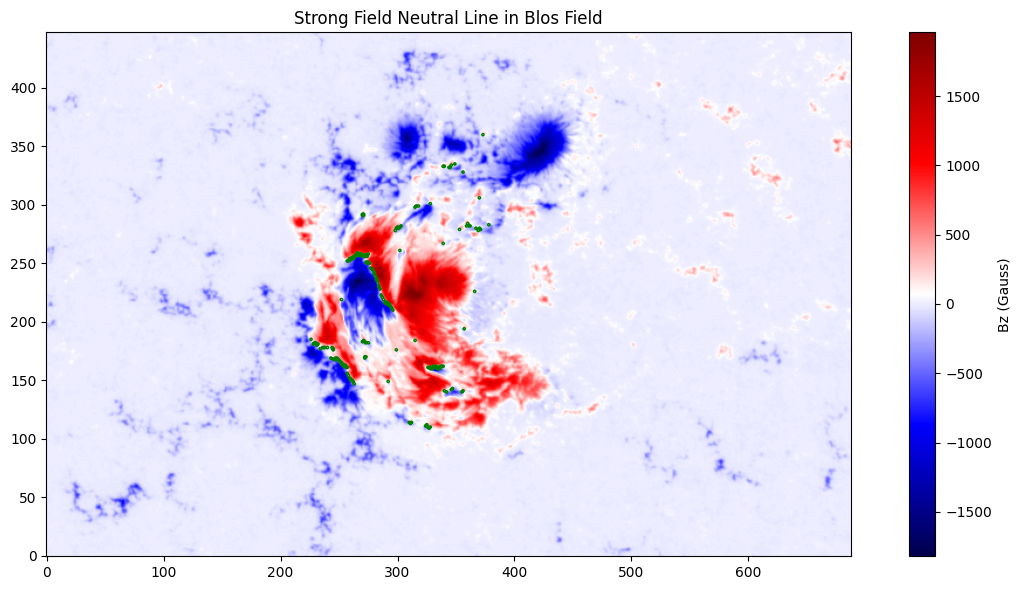

In [50]:
from scipy.ndimage import label
blos.shape

# Step 1: Define the "strong field" threshold (e.g., > 200 G)
strong_field_threshold = 100  # Gauss

# Step 2: Identify the neutral line where Bz changes polarity and magnetic field is strong
strong_field_mask = np.abs(blos) > strong_field_threshold  # Mask where field strength is strong
neutral_line_mask = np.logical_and(blos > 0, np.roll(blos, 1, axis=0) < 0) | \
                     np.logical_and(blos < 0, np.roll(blos, -1, axis=0) > 0)

# Combine both conditions (strong field + neutral line)
neutral_line_strong_field_mask = np.logical_and(strong_field_mask, neutral_line_mask)

# Step 3: Label and find connected regions along the neutral line
labeled, num_labels = label(neutral_line_strong_field_mask)

# Step 4: Calculate the length of the neutral line (in pixels)
neutral_line_length_pixels = np.sum(neutral_line_strong_field_mask)
print(f"Length of Strong Field Neutral Line (in pixels): {neutral_line_length_pixels}")

# Step 5: Visualize the neutral line on the magnetic field map
plt.figure(figsize=(12, 6))

# Plot Bz field with neutral line highlighted
plt.imshow(blos, cmap='seismic', origin='lower')
plt.colorbar(label='Bz (Gauss)')
plt.contour(neutral_line_strong_field_mask, colors='green', linewidths=2)
plt.title('Strong Field Neutral Line in Blos Field')
#plt.colorbar(label='Bz (Gauss)')

plt.tight_layout()
plt.show()


The binary grow algorithm is a method used for neutral line detection in solar magnetic fields (e.g., from magnetograms). It is particularly useful in detecting the neutral line where the magnetic field changes polarity, which is a key feature in understanding solar activity such as solar flares and CMEs.

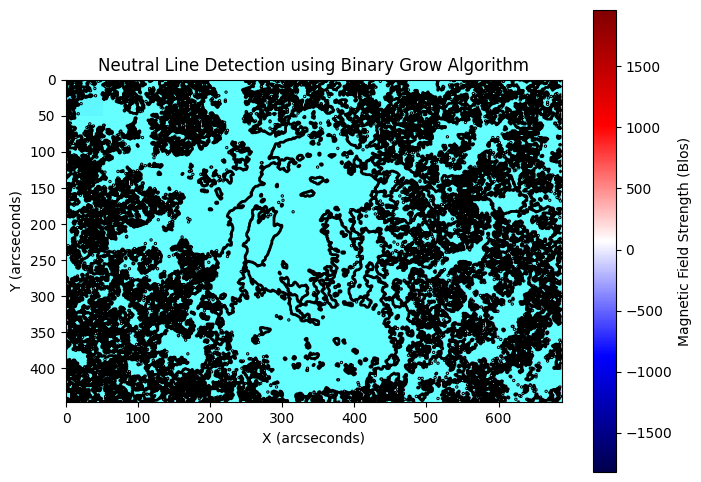

In [54]:
#Detecting Neutral line using Binary grow algorithm.
from scipy.ndimage import label, generate_binary_structure

# Step 1: Load or simulate a magnetogram (positive and negative magnetic field values)
blos.shape
nx=blos.shape[0]
ny=blos.shape[1]

# Step 2: Create a binary mask (1 for positive field, 0 for negative field)
Blos_binary = np.where(blos >= 0, 1, 0)

# Step 3: Find boundary points where the polarity changes
# We will find points where Blos transitions from positive to negative and vice versa
boundary_mask = np.zeros_like(Blos_binary)

# Check neighboring pixels to identify boundaries (edges between positive and negative fields)
for i in range(1, nx-1):
    for j in range(1, ny-1):
        if Blos_binary[i, j] != Blos_binary[i+1, j] or Blos_binary[i, j] != Blos_binary[i, j+1]:
            boundary_mask[i, j] = 1  # Mark the boundary pixel

# Step 4: Grow the boundary region to identify the neutral line
# We will use a simple flood fill (region growing) to expand the boundary region

# Create a structure to define neighbors (4-connectivity)
structure = generate_binary_structure(2, 1)

# Label the connected regions (regions of interest or neutral line regions)
labeled_array, num_features = label(boundary_mask, structure)

# Step 5: Visualize the result
plt.figure(figsize=(8, 6))

# Plot the original magnetic field
plt.imshow(blos, cmap='seismic', origin='lower', extent=[-50, 50, -50, 50])
plt.colorbar(label='Magnetic Field Strength (Blos)')
plt.contour(Blos_binary, levels=[0.5], colors='k', linewidths=2)  # Neutral line contour

# Overlay the boundary and neutral line regions
plt.imshow(labeled_array, cmap='cool', alpha=0.6)  # Display the regions with neutral line
plt.title('Neutral Line Detection using Binary Grow Algorithm')
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.show()


The Strong-Field Neutral Line (SFNL) is a segment of the Polarity Inversion Line (PIL) where:

The field strength (typically |Bz| or |Bh|) exceeds a given threshold.
The line lies between opposite polarities (zero-crossing region).

To calculate the neutral line (also known as the Polarity Inversion Line or PIL) from HMI magnetogram data and estimate its length, a common and simple approach is to:

Load the line-of-sight (LOS) or vector magnetic field data.
Identify the zero-crossing region between positive and negative polarities. Use a binary grow algorithm (or morphological dilation around a thresholded mask) to detect the neutral line. Calculate the length of this line using pixel counting and resolution scaling.

Length of Strong Field Neutral Line: 42.99 Mm
R parameter (Schrijver): 1.87e+06 Mx


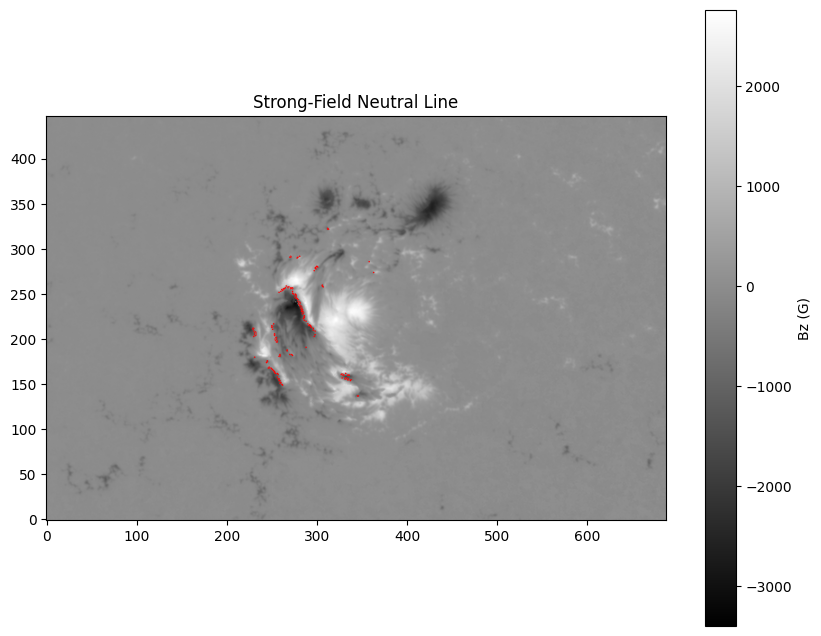

In [56]:

from astropy.io import fits
from skimage import morphology, measure

# --- Load HMI Blos magnetogram ---
blos.shape

# --- Step 1: Basic polarity masks ---
pos_mask = blos > 50
neg_mask = blos < -50

# --- Step 2: Dilate to find overlap/neutral line ---
dilated_pos = morphology.binary_dilation(pos_mask, morphology.disk(1))
dilated_neg = morphology.binary_dilation(neg_mask, morphology.disk(1))
neutral_line = np.logical_and(dilated_pos, dilated_neg)

# --- Step 3: Strong field mask (e.g., |Bz| > 150 G) ---
strong_field_mask = np.abs(blos) > 150

# --- Step 4: Combine to find Strong Field Neutral Line (SFNL) ---
sf_pil = np.logical_and(neutral_line, strong_field_mask)

# --- Step 5: Calculate physical length of SFNL ---
pix_size_Mm = 0.36  # HMI pixel scale in megameters
labeled = measure.label(sf_pil)
regions = measure.regionprops(labeled)
sf_length_px = sum([r.perimeter for r in regions])
sf_length_Mm = sf_length_px * pix_size_Mm

print(f"Length of Strong Field Neutral Line: {sf_length_Mm:.2f} Mm")

# --- Optional: Compute R parameter (Schrijver 2007) ---
# R = sum(|Bz| near SFNL, within 15 Mm)
from scipy.ndimage import binary_dilation

sf_pil_dilated = binary_dilation(sf_pil, structure=morphology.disk(int(15 / pix_size_Mm)))
blos_abs = np.abs(blos)
R_flux = np.sum(blos_abs[sf_pil_dilated]) * (pix_size_Mm**2)  # flux in Mx

print(f"R parameter (Schrijver): {R_flux:.2e} Mx")

# --- Plot result ---
plt.figure(figsize=(10, 8))
plt.imshow(bz, cmap='gray', origin='lower')
plt.colorbar(label='Bz (G)')
plt.contour(sf_pil, colors='red', linewidths=0.5)
plt.title('Strong-Field Neutral Line')
#plt.colorbar(label='Bz (G)')
plt.show()
